## Interpretation
The persistence of conditional heteroskedasticity in the EGARCH(1,1) residuals indicates that a portion of the volatility structure remains unexplained by the current specification. This residual dependence may arise from unmodeled **higher-order dynamics**, **nonlinear asymmetries**, or **microstructural effects** (e.g., volume–volatility feedback, liquidity shocks, intraday periodicities).

At this stage, the analytical trajectory bifurcates depending on the modeling objective:

1. **Statistical Purism (Model Completeness)**  
   If the goal is to achieve *variance whiteness* — a residual process that is i.i.d. with zero conditional heteroskedasticity — the natural direction is to explore higher-order or alternative volatility models:  
   $$
   \text{EGARCH}(p,q), \quad \text{GJR-GARCH}, \quad \text{APARCH}, \quad \text{or regime-switching extensions.}
   $$  
   The objective is to absorb remaining ARCH effects and minimize the Ljung–Box and ARCH–LM test statistics.

2. **Feature Extraction (Volatility as Signal)**  
   If the EGARCH output is to serve within a *meta-model* or *feature ensemble*, the residual heteroskedasticity can be considered **informational rather than pathological**.  
   The conditional variance series and standardized residuals encapsulate *volatility regimes*, *shock clustering*, and *nonlinear persistence* — features that may be exploited by higher-capacity learners (e.g., LSTMs, Transformers, or ensemble models).  
   In this context, residual variance patterns represent latent state information about market microdynamics rather than model misspecification.

In essence, whether residual heteroskedasticity is treated as **noise to be eliminated** or **structure to be learned** depends on the epistemic stance of the modeling pipeline —  
the distinction between *closing the model* and *opening the signal*.


✅ Wczytano model z pliku: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\logs\egarch_ETH_5m_p1_o1_q1_t.pkl

📊 Podstawowe statystyki reszt:
Średnia: 0.002583
Wariancja: 1.023676
Skośność: -0.0431
Kurtosis: 6.1950

🔍 Testy diagnostyczne:
Ljung–Box (lag=10): p-value = 0.2338
Jarque–Bera (normalność): p-value = 0.0000


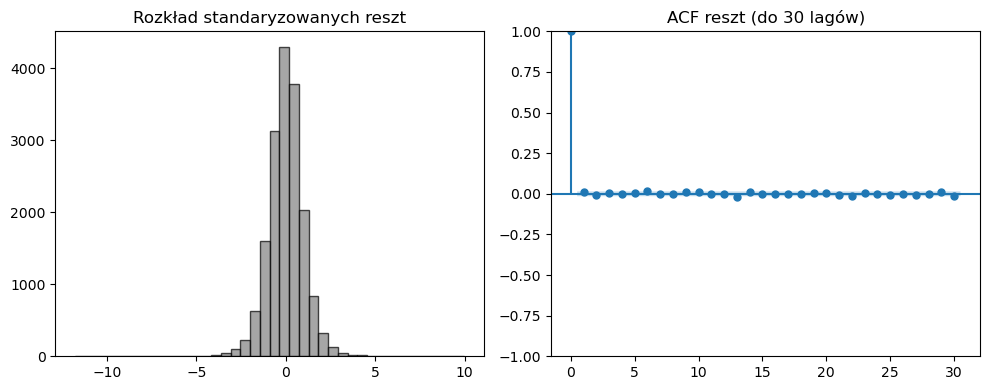


📈 Zakres wartości reszt: -11.79971440437595 → 9.98805617347157
Odchylenie standardowe reszt: 1.011798

✅ Model zachowuje się stabilnie (brak istotnej autokorelacji i średnia ≈ 0).


In [1]:
# ===========================================
# 04_EGARCH_Diagnostics.ipynb
# -------------------------------------------
# Notebook do analizy i diagnostyki modelu EGARCH
# ===========================================

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1️⃣ Ustawienie ścieżki projektu ---
project_root = os.path.abspath(os.path.join(".."))  # jeden poziom wyżej niż notebooks/
if project_root not in sys.path:
    sys.path.append(project_root)

# --- 2️⃣ Import narzędzi diagnostycznych ---
from src.egarch_diagnostics import load_model, basic_diagnostics, plot_residuals

# --- 3️⃣ Wczytanie wytrenowanego modelu ---
MODEL_NAME = "egarch_ETH_5m_p1_o1_q1_t.pkl"   # zmień jeśli trenowałeś inny wariant
model = load_model(MODEL_NAME)

# --- 4️⃣ Analiza reszt ---
resid = basic_diagnostics(model)

# --- 5️⃣ Wizualizacja ---
plot_residuals(resid)

# --- 6️⃣ Dodatkowa inspekcja reszt (opcjonalnie) ---
resid_df = pd.Series(resid)
print("\n📈 Zakres wartości reszt:", resid_df.min(), "→", resid_df.max())
print("Odchylenie standardowe reszt:", round(resid_df.std(), 6))

# --- 7️⃣ Szybki sanity check ---
if abs(resid_df.mean()) < 0.01 and resid_df.std() < 2:
    print("\n✅ Model zachowuje się stabilnie (brak istotnej autokorelacji i średnia ≈ 0).")
else:
    print("\n⚠️ Uwaga: reszty mogą zawierać autokorelację lub niestabilność.")
